ARIMA models


In [1]:
import pandas as pd
import numpy as np


#data from 20th sep 2022 to 20th oct 

df= pd.read_csv('/Users/fytian/Desktop/fintech_socie/NVDA copy.csv')
df.columns=['Date','p1','p2','p3','p4','adj_close','v']
df=df[['Date','adj_close']] # only want the close_price
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

# add frequency to index so arima model can recognise
new_freq = 'B'  
df = df.resample(new_freq).last()
df = df.fillna(method='ffill')
df

,adj_close
Date,
2022-09-26,122.205246
2022-09-27,124.054108
2022-09-28,127.282150
2022-09-29,122.125298
2022-09-30,121.315796
...,...
2023-10-13,454.609985
2023-10-16,460.950012
2023-10-17,439.380005


Check wether stationary using the Augmented Dickey Fuller test (adfuller())

In [2]:
from statsmodels.tsa.stattools import adfuller
from numpy import log


result = adfuller(df.adj_close.dropna(),autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.953658
p-value: 0.769789


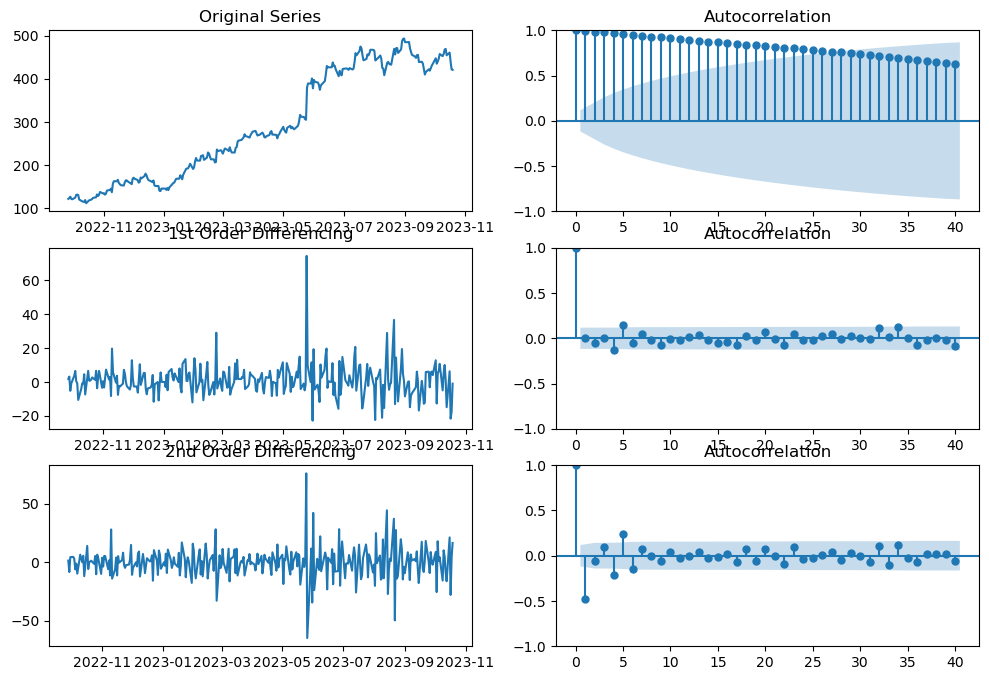

In [3]:
#p value > 0.05 , differencing is needed to make it more stationary , plot how do the time series 
#of different order of differencing  look like , and their repsective ACF



from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

#without differencing 
fig, axes = plt.subplots(3, 2,figsize=(12, 8), sharex=False)
axes[0, 0].plot(df.adj_close); axes[0, 0].set_title('Original Series')
plot_acf(df.adj_close,lags=40, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.adj_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.adj_close.diff().dropna(),lags=40, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.adj_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.adj_close.diff().diff().dropna(),lags=40, ax=axes[2, 1])

plt.show()

In [4]:
# See what parameters does auto selction of model give


from pmdarima import auto_arima
import warnings
#ignore harmless warning
warnings.filterwarnings('ignore')

stepwise_fit=auto_arima(df.adj_close,m=7,
                          seasonal=True,
                          trace=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2030.315, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2033.745, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2033.712, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2032.037, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=2031.751, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2031.720, Time=0.21 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2033.571, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2032.314, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=2032.314, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=2026.791, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=2028.554, Time=0.58 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=2028.546, Time=0.17 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=2030.508, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : 

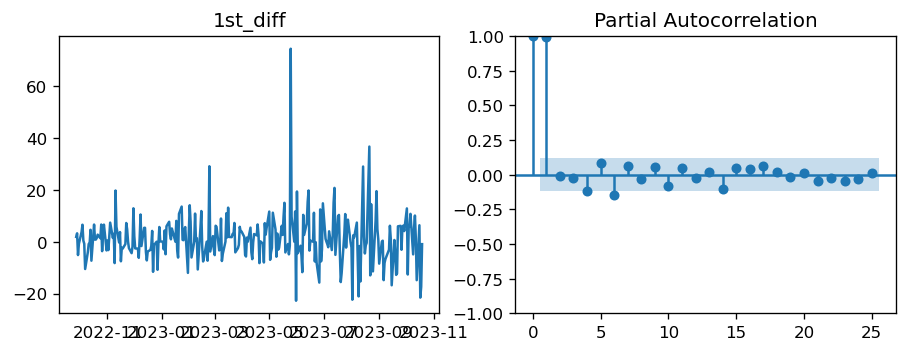

In [5]:
# Model has propose to use 1st order differencing , but p as 2 and q as 2 
#I will proceed with 1st differentcing(d=1) ,however  i will manually choose a P and q value  from its respective PACF , acf , 

# PACF plot of difference 1 series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.adj_close.diff()); axes[0].set_title('1st_diff')
axes[1].set(ylim=(0,5))
plot_pacf(df.adj_close.dropna(), ax=axes[1])

plt.show()

the PACF of lag 1 is significant while All other lag are insignificant , together with the fact that acf of 1st_differencing series decay exponentially,

I am chooshing p=1 and q= 0.
so final model selection is Arima(1,1,0) (will compare with auto_arima model later) 


In [13]:
# see some sumamry stats of this model 

import statsmodels.api as sm

#1,1,0 ARIMA Model
model = sm.tsa.arima.ARIMA(df.adj_close
                        , order=(1,1,0),freq='B')


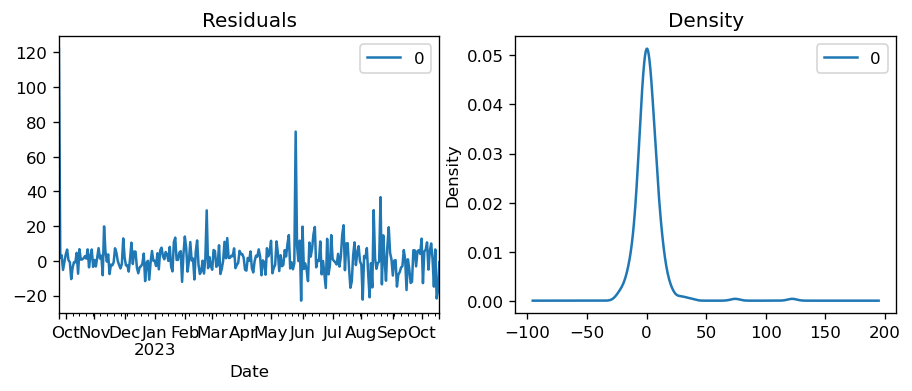

In [14]:
#plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

residuals = pd.DataFrame(model.fit().resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.

#now see how the model perform using train test data


In [15]:
train=df.adj_close[:175]
test=df.adj_close[174:] 

fitted = model.fit()

forecast=fitted.predict(start='2023-05-26',end='2023-10-20',alpha=0.03)
forecast

2023-05-26    380.844926
2023-05-29    389.532403
2023-05-30    389.387604
2023-05-31    401.210060
2023-06-01    377.928371
                 ...    
2023-10-16    454.387498
2023-10-17    461.045064
2023-10-18    439.056619
2023-10-19    421.698823
2023-10-20    420.995768
Freq: B, Name: predicted_mean, Length: 106, dtype: float64

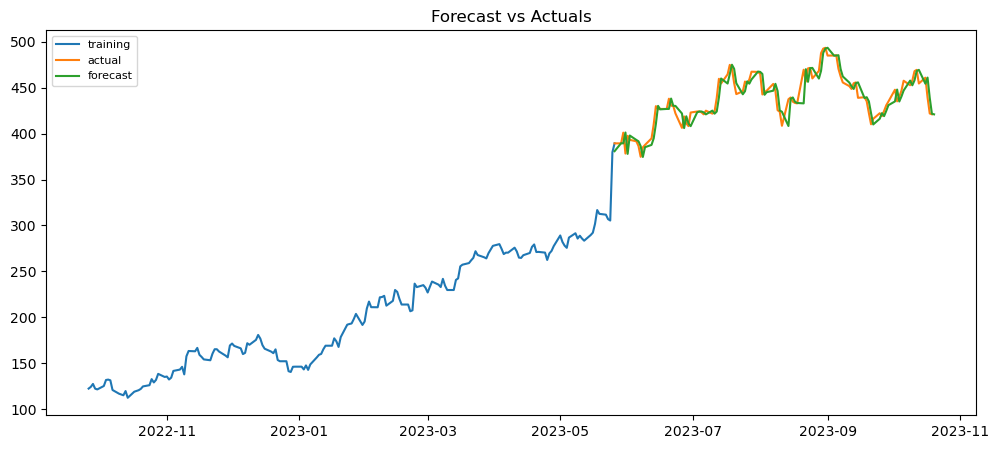

In [16]:
# plot the graph and see how prediction goes 

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(1,1，0) model seems to give a close to true value forecast. 

I will compute the RMSE to see 

In [17]:

squared_diff = (test - forecast) ** 2

mean_squared_diff = squared_diff.mean()

rmse = np.sqrt(mean_squared_diff)

print(f"RMSE: {rmse:.2f}")

RMSE: 10.71


Now try to see how auto arima perform 

In [18]:


import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
stepwise_model = pm.auto_arima(df, 
                         m=7,
                          seasonal=True,
                          trace=True, 
                         stepwise=True)

stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2030.315, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2033.745, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2033.712, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2032.037, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=2031.751, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2031.720, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2033.571, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2032.314, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=2032.314, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=2026.791, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=2028.554, Time=0.21 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=2028.546, Time=0.15 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=2030.508, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  279
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1006.441
Date:                Tue, 24 Oct 2023   AIC                           2024.882
Time:                        23:14:52   BIC                           2046.647
Sample:                    09-26-2022   HQIC                          2033.614
                         - 10-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5268      2.110      1.671      0.095      -0.609       7.663
ar.L1         -1.5860      0.206     -7.711      0.000      -1.989      -1.183
ar.L2         -0.7262      0.165     -4.398      0.000      -1.050      -0.403
ma.L1          1.6270      0.228      7.148      0.000       1.181       2.073
ma.L2          0.7049      0.212      3.318      0.001       0.288       1.121
sigma2        81.5882      2.969     27.477      0.000      75.768      87.408
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2467.52
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.54   Skew:                             1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=130)


In [62]:
date_index = pd.date_range(start='2023-05-26', periods=120, freq='B')
future_forecast = pd.DataFrame(future_forecast,index = date_index,columns=['Prediction'])


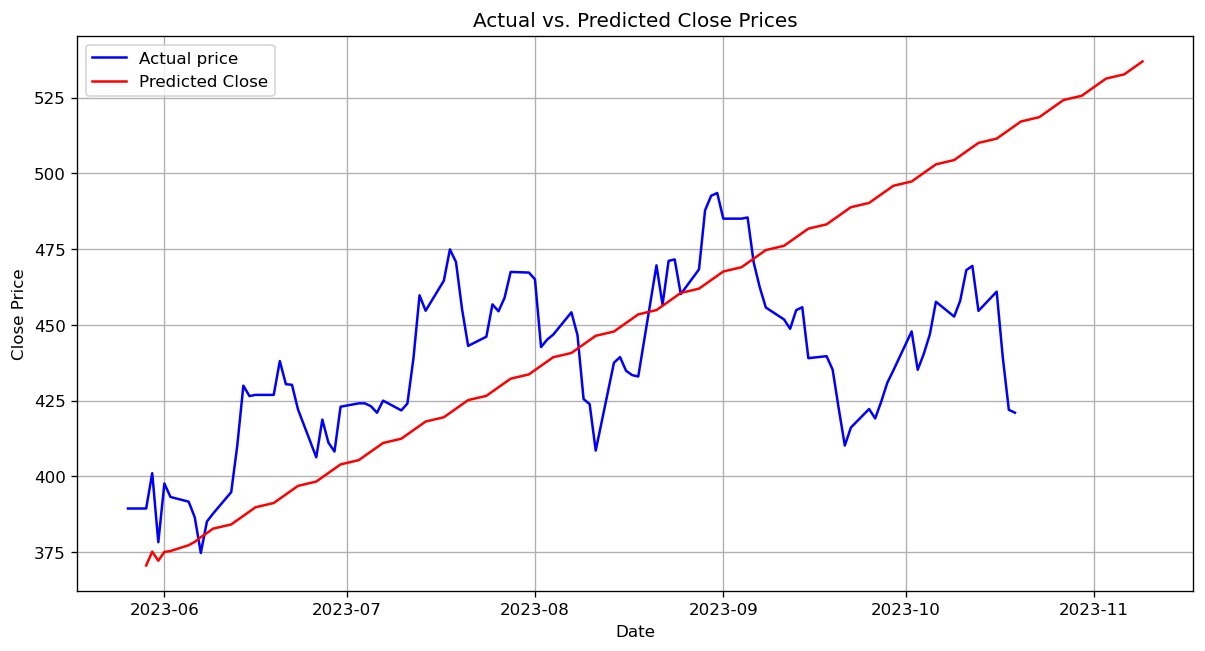

In [63]:

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot 'test' in blue
plt.plot(test.index, test, color='blue', label='Actual price')

# Plot 'forecast' in red
plt.plot(future_forecast.index, future_forecast['Prediction'], color='red', label='Predicted Close')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Prices')
plt.legend()
plt.grid(True)
plt.show()



It captured an upward trend  , however it does not capture the flucatuation.  

In [64]:
future_forecast.Prediction

2023-05-26           NaN
2023-05-29    370.586514
2023-05-30    375.142574
2023-05-31    372.158423
2023-06-01    375.058280
                 ...    
2023-11-03    531.264706
2023-11-06    532.679445
2023-11-07    534.094185
2023-11-08    535.508925
2023-11-09    536.923664
Freq: B, Name: Prediction, Length: 120, dtype: float64

In [23]:
# calculate the RMSE , it is way higher than the ARIMA model selected above
squared_diff = (test - future_forecast.Prediction) ** 2

mean_squared_diff = squared_diff.mean()

rmse = np.sqrt(mean_squared_diff)

print(f"RMSE: {rmse:.2f}")


RMSE: 36.75


To conclude, ARIMA model (1,1,0) has a lower RMSE than auto arima which select parameter as (2,1,2)
so the final selection model is ARIMA(1,1,0) 

To extrapolate data , i will use Arima model (1,1,0) to predict from 25th Oct to 7th Nov

In [25]:
forecast=fitted.predict(start='2023-10-25',end='2023-11-07',alpha=0.03)
forecast

2023-10-25    420.995551
2023-10-26    420.995551
2023-10-27    420.995551
2023-10-30    420.995551
2023-10-31    420.995551
2023-11-01    420.995551
2023-11-02    420.995551
2023-11-03    420.995551
2023-11-06    420.995551
2023-11-07    420.995551
Freq: B, Name: predicted_mean, dtype: float64

There is some error with my prediction , i will use autorima model instead to output the csv

In [65]:
future_forecast.Prediction

2023-05-26           NaN
2023-05-29    370.586514
2023-05-30    375.142574
2023-05-31    372.158423
2023-06-01    375.058280
                 ...    
2023-11-03    531.264706
2023-11-06    532.679445
2023-11-07    534.094185
2023-11-08    535.508925
2023-11-09    536.923664
Freq: B, Name: Prediction, Length: 120, dtype: float64

In [66]:
start_date = '2023-10-25'
end_date = '2023-11-07'

selected_data = future_forecast['Prediction'].loc[start_date:end_date]

In [81]:
new_df = pd.DataFrame({'index': range(10), 'Close': selected_data})
new_df = new_df.set_index('index', drop=True)
new_df

,Close
index,
0,521.361528
1,522.776268
2,524.191007
3,525.605747
4,527.020487
5,528.435226
6,529.849966
7,531.264706
8,532.679445


In [83]:

# Save the DataFrame to a CSV file at the specified path
file_path = '/Users/fytian/Desktop/fintech_socie/selected_data.csv'
new_df.to_csv(file_path)